# ANALISIS DE FRAUDE FINANCIERO

In [1]:
# Carga Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

## Análisis Exploratorio de Datos

In [2]:
# Cargar el dataset
file_path = 'Fraud.csv'
df = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset
df.head()

# Análisis exploratorio de datos (EDA)
print("Información del Dataset:")
print(df.info())

print("\nEstadísticas Descriptivas del Dataset:")
print(df.describe())

print("\nDistribución de la Variable Objetivo (isFraud):")
print(df['isFraud'].value_counts(normalize=True))

Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

Estadísticas Descriptivas del Dataset:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   

In [3]:
# Cambio de nombre de las columnas
column_mapping = {
    'step': 'paso',
    'type': 'tipo_transaccion',
    'amount': 'monto',
    'nameOrig': 'nombre_cliente_origen',
    'oldbalanceOrg': 'saldo_antes_origen',
    'newbalanceOrig': 'saldo_despues_origen',
    'nameDest': 'nombre_cliente_destino',
    'oldbalanceDest': 'saldo_antes_destino',
    'newbalanceDest': 'saldo_despues_destino',
    'isFraud': 'es_fraude',
    'isFlaggedFraud': 'es_marcado_fraude'
}

# Aplicar los cambios
df.rename(columns=column_mapping, inplace=True)

# Mostrar datos
df.head()

,paso,tipo_transaccion,monto,nombre_cliente_origen,saldo_antes_origen,saldo_despues_origen,nombre_cliente_destino,saldo_antes_destino,saldo_despues_destino,es_fraude,es_marcado_fraude
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.isnull().sum()

paso                      0
tipo_transaccion          0
monto                     0
nombre_cliente_origen     0
saldo_antes_origen        0
saldo_despues_origen      0
nombre_cliente_destino    0
saldo_antes_destino       0
saldo_despues_destino     0
es_fraude                 0
es_marcado_fraude         0
dtype: int64

In [5]:
df.duplicated().sum()

0

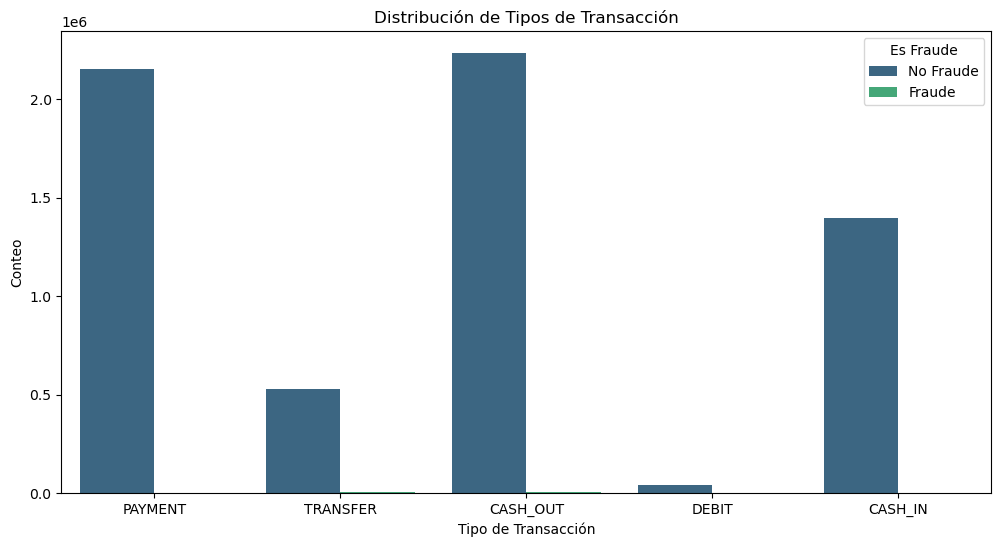

In [6]:
# Distribución de tipos de transacción
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='tipo_transaccion', hue='es_fraude', palette='viridis')
plt.title('Distribución de Tipos de Transacción')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Conteo')
plt.legend(title='Es Fraude', labels=['No Fraude', 'Fraude'])
plt.show()

In [7]:
# Transformar la variable categórica 'tipo_transaccion' usando one-hot encoding
df = pd.get_dummies(df, columns=['tipo_transaccion'], drop_first=True)

In [8]:
# Seleccionar variables relevantes para el modelo
variables_relevantes = [
    'paso', 'monto', 'saldo_antes_origen', 'saldo_despues_origen', 'saldo_antes_destino',
    'saldo_despues_destino', 'tipo_transaccion_CASH_OUT', 'tipo_transaccion_DEBIT', 'tipo_transaccion_PAYMENT',
    'tipo_transaccion_TRANSFER'
]

In [9]:
# Crear el nuevo DataFrame con las variables seleccionadas
data_model = df[variables_relevantes + ['es_fraude']]

#### Visualización de la Distribución de las Transacciones Fraudulentas

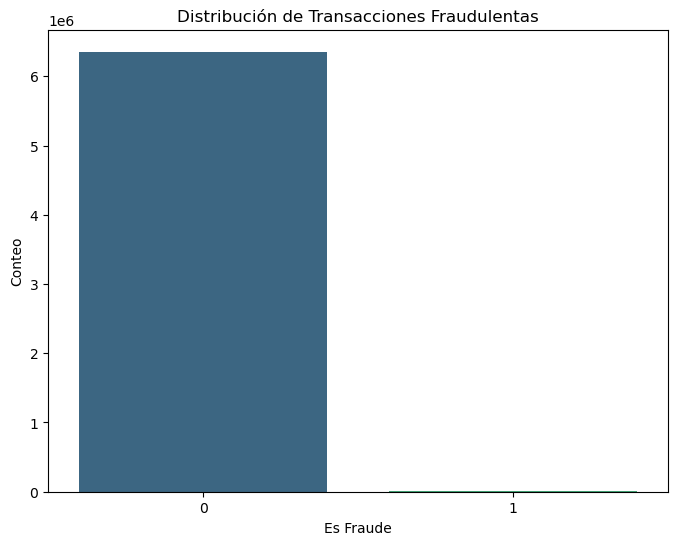

In [10]:
# Distribución de la variable 'es_fraude'
plt.figure(figsize=(8, 6))
sns.countplot(x='es_fraude', data=data_model, palette='viridis')
plt.title('Distribución de Transacciones Fraudulentas')
plt.xlabel('Es Fraude')
plt.ylabel('Conteo')
plt.show()

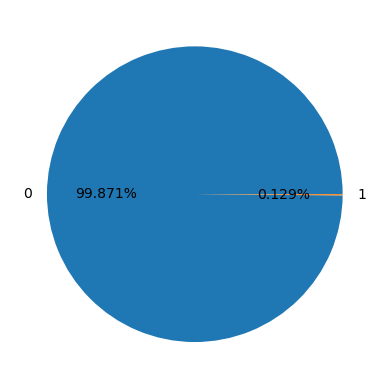

In [11]:
plt.pie(data_model["es_fraude"].value_counts(),labels=data_model["es_fraude"].unique(),autopct='%1.3f%%')
plt.show()

In [12]:
data_model["es_fraude"].value_counts()

es_fraude
0    6354407
1       8213
Name: count, dtype: int64

#### Análisis de la Distribución de las Variables Numéricas

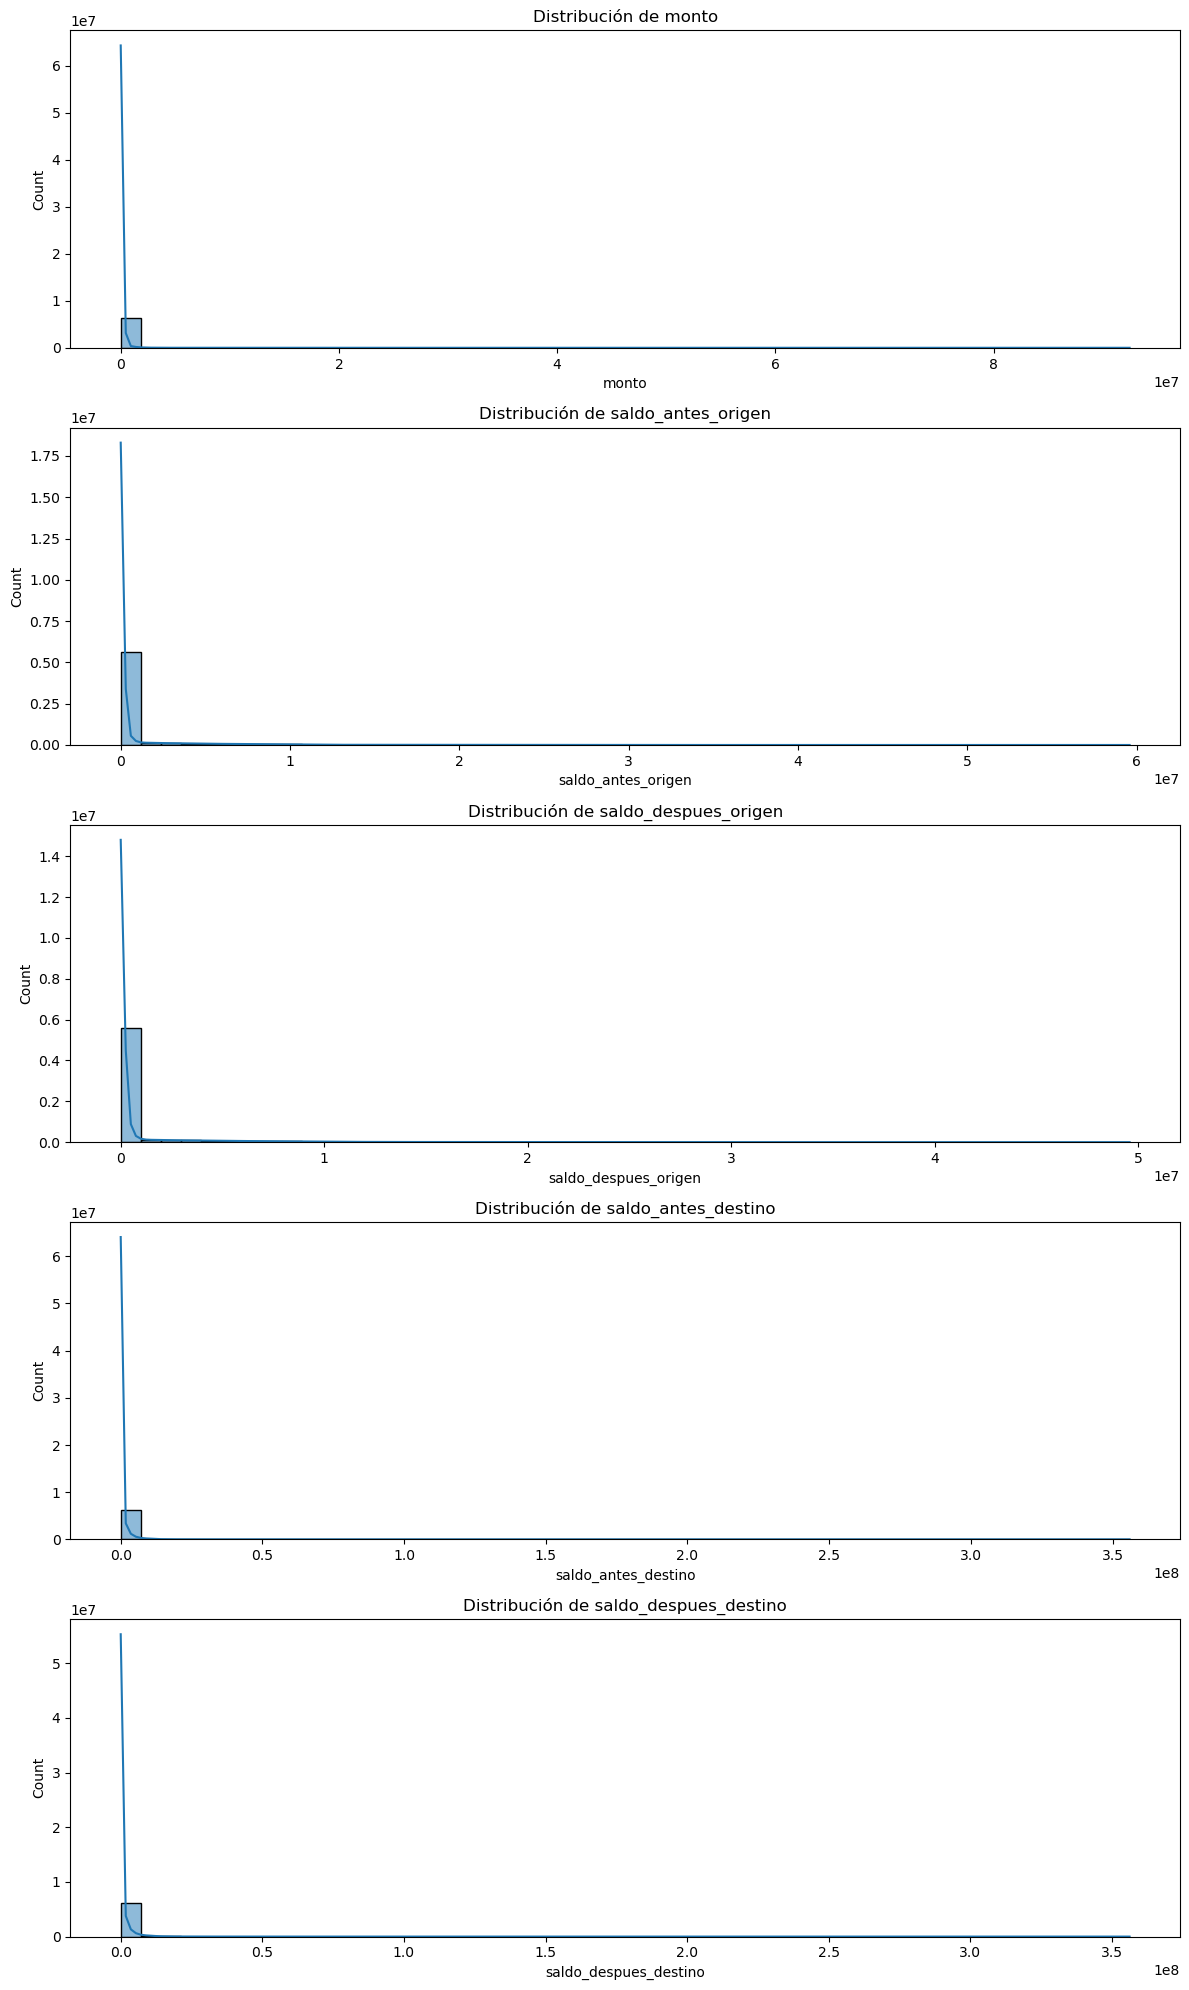

In [13]:
# Histograma de las variables numéricas
variables_numericas = ['monto', 'saldo_antes_origen', 'saldo_despues_origen', 'saldo_antes_destino', 'saldo_despues_destino']

fig, axs = plt.subplots(len(variables_numericas), 1, figsize=(12, 20))
for i, var in enumerate(variables_numericas):
    sns.histplot(data_model[var], bins=50, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribución de {var}')
plt.tight_layout()
plt.show()

#### Boxplots para Identificar Valores Atípicos

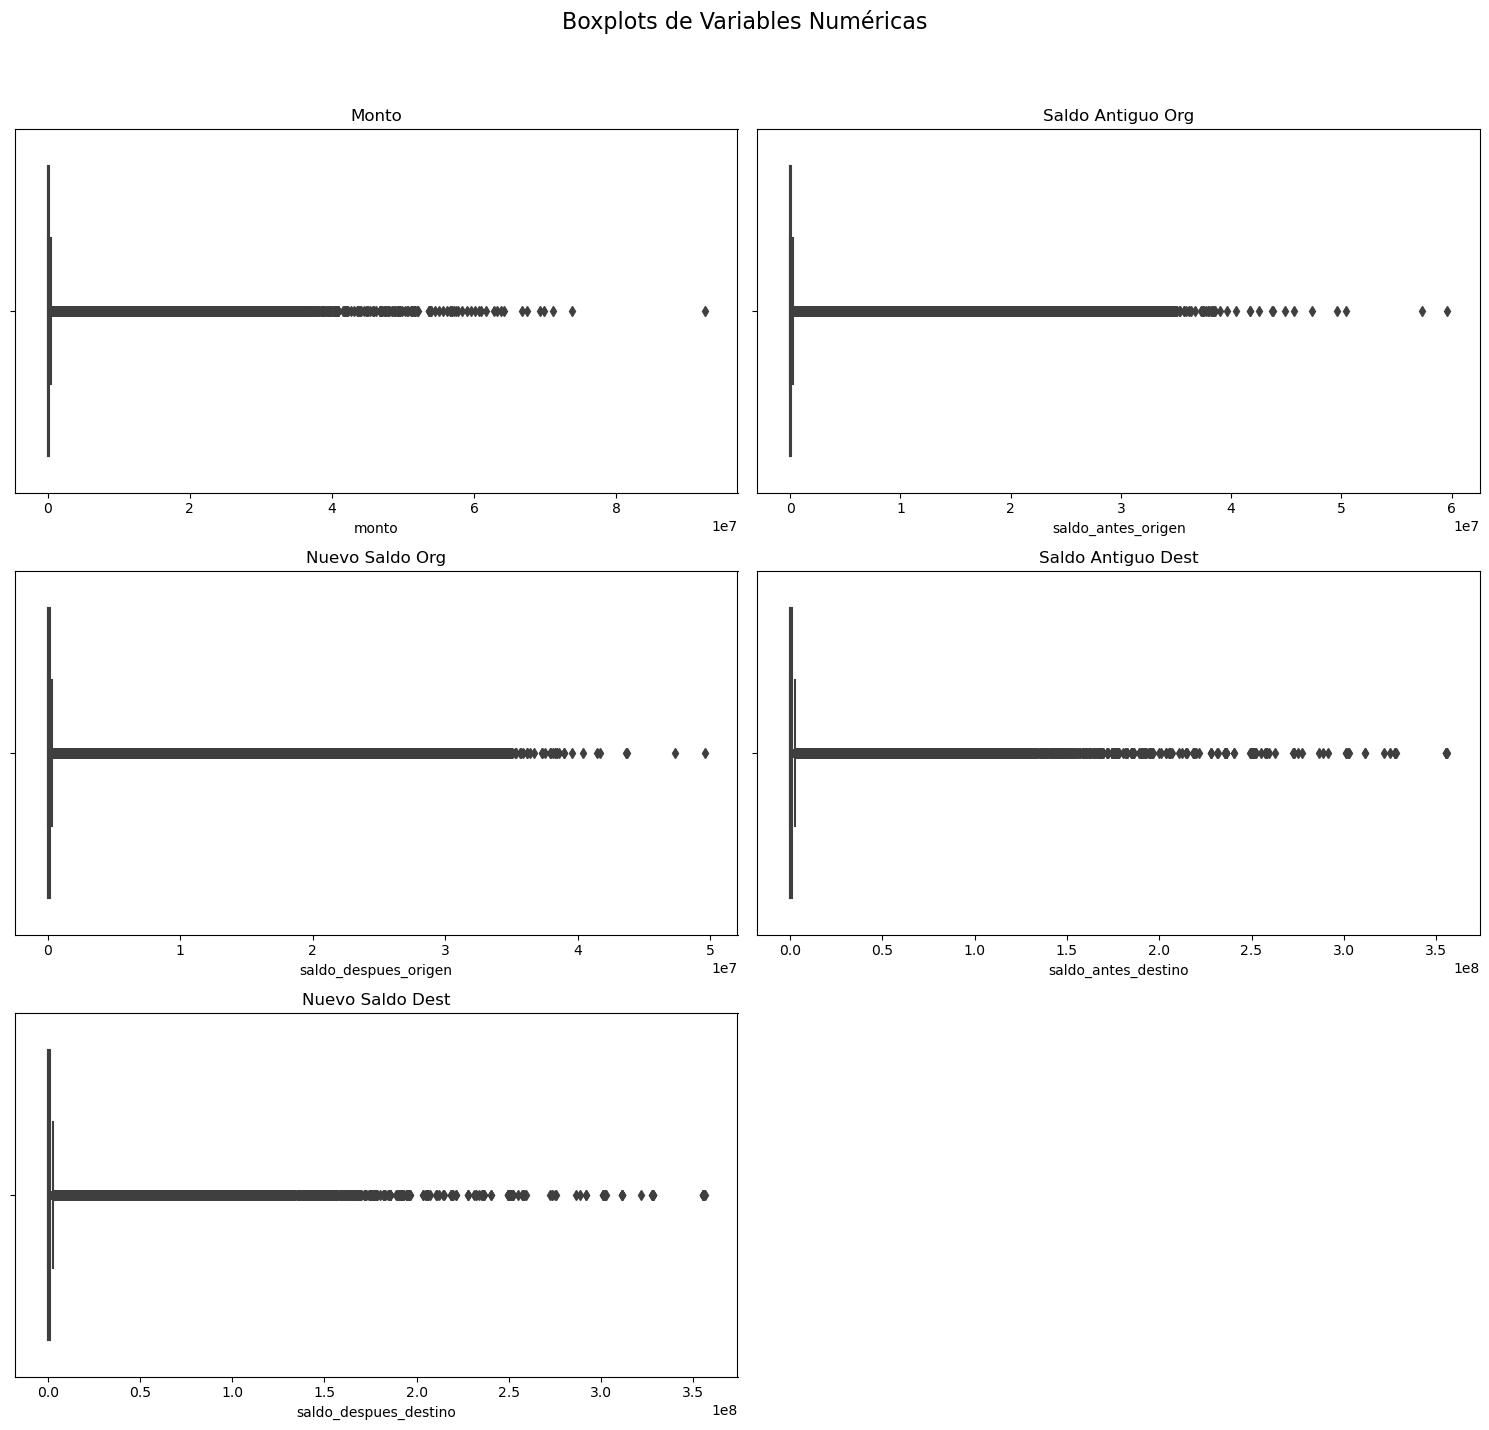

In [14]:
# Identificación de valores atípicos usando gráficos de caja (boxplots)
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Boxplots de Variables Numéricas', fontsize=16)

sns.boxplot(data=data_model, x='monto', ax=axs[0, 0])
axs[0, 0].set_title('Monto')

sns.boxplot(data=data_model, x='saldo_antes_origen', ax=axs[0, 1])
axs[0, 1].set_title('Saldo Antiguo Org')

sns.boxplot(data=data_model, x='saldo_despues_origen', ax=axs[1, 0])
axs[1, 0].set_title('Nuevo Saldo Org')

sns.boxplot(data=data_model, x='saldo_antes_destino', ax=axs[1, 1])
axs[1, 1].set_title('Saldo Antiguo Dest')

sns.boxplot(data=data_model, x='saldo_despues_destino', ax=axs[2, 0])
axs[2, 0].set_title('Nuevo Saldo Dest')

# Ocultar el último subplot vacío
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Matriz de Correlación

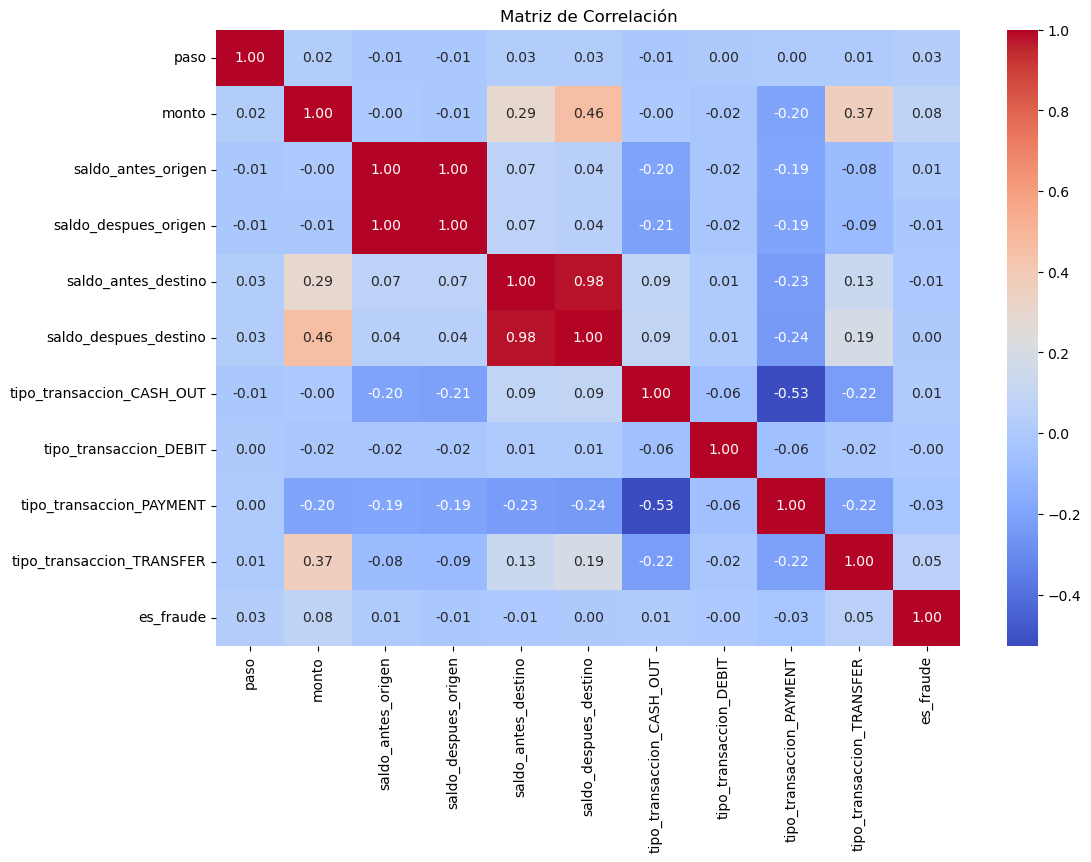

In [15]:
# Matriz de correlación
matriz_correlacion = data_model.corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm')
#sns.heatmap(matriz_correlacion, annot = True, cmap="Accent")
plt.title("Matriz de Correlación")
plt.show()


### Preparación para el entrenamiento de modelos

In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = data_model.drop('es_fraude', axis=1)
y = data_model['es_fraude']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Modelo Random Forest

In [18]:
# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilidades = rf_model.predict_proba(X_test)[:, 1]

In [19]:
# Evaluar el modelo
print("\nReporte Random Forest:\n")
print(classification_report(y_test, rf_predictions))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_probabilidades))


Reporte Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.77      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9948082616682806


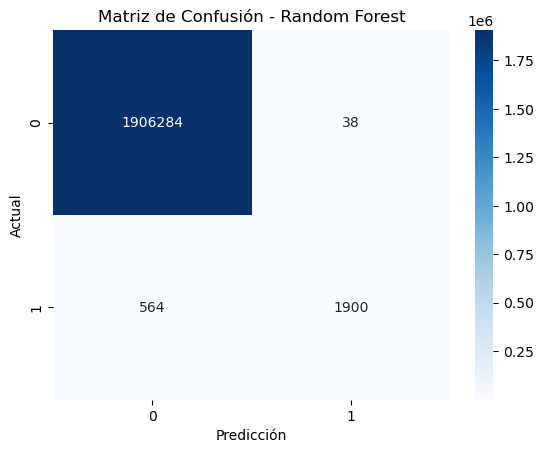

In [21]:
# Matriz de Confusión
confusion_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

### Modelo Árbol de Decisión

In [22]:
# Crear y entrenar el modelo Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_probabilidades = dt_model.predict_proba(X_test)[:, 1]

In [23]:
# Evaluar el modelo
print("\nReporte Árbol de Decisión:\n")
print(classification_report(y_test, dt_predictions))
print("ROC-AUC Score:", roc_auc_score(y_test, dt_probabilidades))


Reporte Árbol de Decisión:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.87      0.85      0.86      2464

    accuracy                           1.00   1908786
   macro avg       0.94      0.92      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9226085273294409


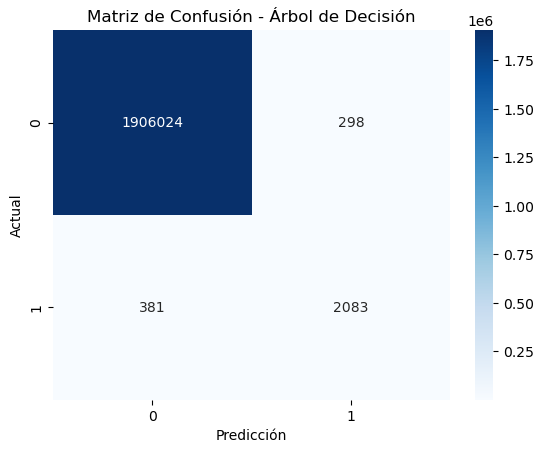

In [24]:
# Matriz de Confusión
confusion_dt = confusion_matrix(y_test, dt_predictions)
sns.heatmap(confusion_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

### Modelo Regresión Logística

In [25]:
# Crear y entrenar el modelo Regresión Logística
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_probabilidades = lr_model.predict_proba(X_test)[:, 1]

In [26]:
# Evaluar el modelo
print("\nReporte Regresión Logística:\n")
print(classification_report(y_test, lr_predictions))
print("ROC-AUC Score:", roc_auc_score(y_test, lr_probabilidades))


Reporte Regresión Logística:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.92      0.06      2464

    accuracy                           0.96   1908786
   macro avg       0.51      0.94      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786

ROC-AUC Score: 0.9852188924391592


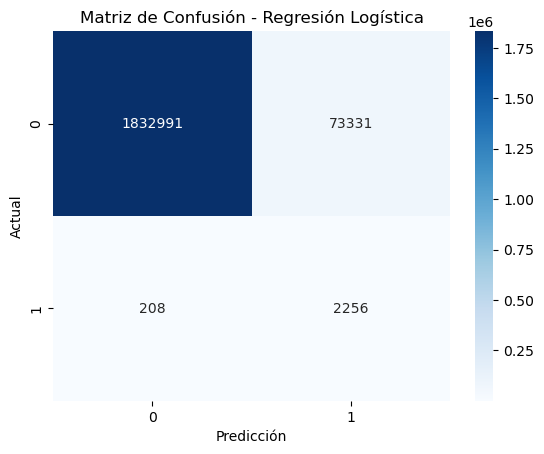

In [27]:
# Matriz de Confusión
confusion_lr = confusion_matrix(y_test, lr_predictions)
sns.heatmap(confusion_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

## Evaluar Modelos

In [28]:
# Evaluar los modelos
rf_report = classification_report(y_test, rf_predictions, output_dict=True)
dt_report = classification_report(y_test, dt_predictions, output_dict=True)
lr_report = classification_report(y_test, lr_predictions, output_dict=True)

In [29]:
# Convertir los reportes a DataFrames para visualización
rf_report_df = pd.DataFrame(rf_report).transpose()
dt_report_df = pd.DataFrame(dt_report).transpose()
lr_report_df = pd.DataFrame(lr_report).transpose()

print("\nReporte Random Forest:")
print(rf_report_df)

print("\nReporte Árbol de Decisión:")
print(dt_report_df)

print("\nReporte Regresión Logística:")
print(lr_report_df)


Reporte Random Forest:
              precision    recall  f1-score       support
0              0.999704  0.999980  0.999842  1.906322e+06
1              0.980392  0.771104  0.863244  2.464000e+03
accuracy       0.999685  0.999685  0.999685  9.996846e-01
macro avg      0.990048  0.885542  0.931543  1.908786e+06
weighted avg   0.999679  0.999685  0.999666  1.908786e+06

Reporte Árbol de Decisión:
              precision    recall  f1-score       support
0              0.999800  0.999844  0.999822  1.906322e+06
1              0.874843  0.845373  0.859856  2.464000e+03
accuracy       0.999644  0.999644  0.999644  9.996443e-01
macro avg      0.937321  0.922609  0.929839  1.908786e+06
weighted avg   0.999639  0.999644  0.999641  1.908786e+06

Reporte Regresión Logística:
              precision    recall  f1-score       support
0              0.999887  0.961533  0.980335  1.906322e+06
1              0.029846  0.915584  0.057808  2.464000e+03
accuracy       0.961473  0.961473  0.961473  9.6

#### Curvas ROC

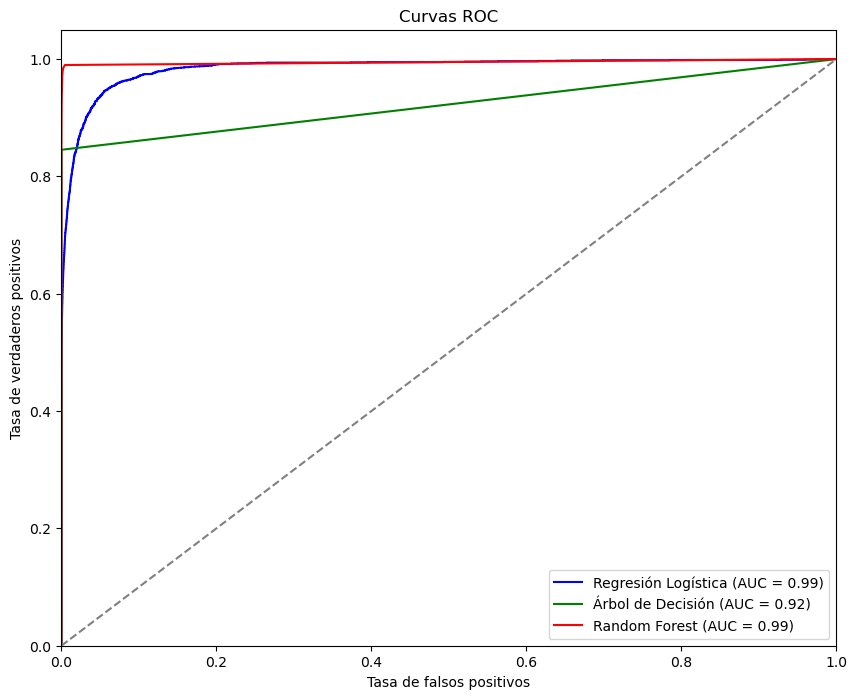

In [30]:
# Curvas ROC
plt.figure(figsize=(10, 8))
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probabilidades)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probabilidades)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probabilidades)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_lr, tpr_lr, color='blue', label=f'Regresión Logística (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, color='green', label=f'Árbol de Decisión (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, color='red', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curvas ROC')
plt.legend(loc="lower right")
plt.show()
